## MiniLab Project Requirments -
1. [Data Preparation](#DataPreparation)
    1. [Data preparation: Adjustments](#DataPrep)
    2. [Data preparation for Support Vector Machine](#SVGDataSet)

[Feature Selection](#FeatureSelection)
  * [VIF Feature Removal](#VIF)
  * [Logistic Regression](#LogsticRegression)
    * [Feature Importance](#FI)
	* [Logistic Refit](#Refit)
	* [GridSearch Results](#GridSearch)


In [6]:
#removing warnings
import warnings
warnings.simplefilter('ignore')

# Import Libraries Required.
# pydata stack
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
 # now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_curve, auc

# others
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from plot_decision_regions import plot_decision_regions

# custom functions
from cleaning import read_clean_data, impute_data
from tables import classification_report
from stats import ReduceVIF

# set random seed
random_state = 1
np.random.seed(random_state)

In [10]:
X_train = pd.read_csv('X_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')
y_train = pd.read_csv('y_train.txt', header = None).values.flatten()
y_test = pd.read_csv('y_test.txt', header = None).values.flatten()

In [3]:
# It was previously determined to drop these columns based on VIF
drop_cols =  ['BUREAU_CREDIT_ACTIVE_Active',
  'DEBT_CREDIT_RATIO',      
  'PREV_NAME_CONTRACT_TYPE_Cash loans',      
  'PREV_NAME_CONTRACT_TYPE_Consumer loans',     
  'PREV_NAME_CONTRACT_TYPE_Revolving loans',      
  'PREV_NAME_CONTRACT_TYPE_XNA',      
  'PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY',      
  'PREV_FLAG_LAST_APPL_PER_CONTRACT_N',      
  'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex',      
  'PREV_NAME_CASH_LOAN_PURPOSE_XAP',      
  'PREV_NAME_CONTRACT_STATUS_Approved',     
  'PREV_NAME_CONTRACT_STATUS_Unused offer',      
  'PREV_NAME_PAYMENT_TYPE_Cash through the bank',      
  'PREV_CODE_REJECT_REASON_CLIENT',      
  'PREV_NAME_CLIENT_TYPE_New',      
  'PREV_NAME_GOODS_CATEGORY_Additional Service',      
  'PREV_NAME_PORTFOLIO_Cards',      
  'PREV_NAME_PORTFOLIO_Cars',      
  'PREV_NAME_PORTFOLIO_Cash',      
  'PREV_NAME_PORTFOLIO_XNA',      
  'PREV_NAME_PRODUCT_TYPE_XNA',      
  'PREV_CHANNEL_TYPE_AP+ (Cash loan)',      
  'PREV_NAME_SELLER_INDUSTRY_Auto technology',      
  'CREDIT_AMT_RECIVABLE',        
  'PREV_NAME_PORTFOLIO_POS',        
  'CREDIT_AMT_TOTAL_RECEIVABLE',        
  'PREV_NAME_CONTRACT_STATUS_Refused',        
  'CREDIT_AMT_RECEIVABLE_PRINCIPAL',        
  'PREV_NAME_YIELD_GROUP_high',        
  'EMPLOYED',        
  'INSTA_DAYS_INSTALMENT',        
  'PREV_NAME_GOODS_CATEGORY_XNA',        
  'PREV_PRODUCT_COMBINATION_POS household with interest',        
  'OBS_60_CNT_SOCIAL_CIRCLE',       
  'PREV_NAME_CASH_LOAN_PURPOSE_XNA',        
  'CREDIT_SK_DPD_DEF',       
  'PREV_NAME_SELLER_INDUSTRY_XNA',       
  'PREV_NFLAG_LAST_APPL_IN_DAY',     
  'CREDIT_AMT_BALANCE',      
  'PREV_CHANNEL_TYPE_Country-wide',   
  'CREDIT_CNT_DRAWINGS_CURRENT',       
  'PREV_AMT_APPLICATION',    
  'PREV_CODE_REJECT_REASON_XAP',  
  'PREV_NAME_PRODUCT_TYPE_x-sell', 
  'PREV_NAME_GOODS_CATEGORY_Mobile', 
  'INSTA_AMT_PAYMENT', 
  'DAYS_EMPLOYED',
  'POS_CNT_INSTALMENT', 
  'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y',
  'AMT_CREDIT', 
  'PREV_AMT_GOODS_PRICE',  
  'CREDIT_AMT_DRAWINGS_CURRENT', 
  'PREV_PRODUCT_COMBINATION_Cash', 
  'CREDIT_INCOME_RATIO', 
  'PREV_PRODUCT_COMBINATION_POS industry with interest', 
  'FLAG_DOCUMENT_3', 
  'PREV_NAME_SELLER_INDUSTRY_Connectivity',
  'REGION_RATING_CLIENT', 
  'PREV_DAYS_TERMINATION',
  'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories',
  'POS_MONTHS_BALANCE',
  'CREDIT_AMT_PAYMENT_TOTAL_CURRENT',
  'REG_REGION_NOT_WORK_REGION',
  'PREV_DAYS_FIRST_DRAWING',
  'CREDIT_NAME_CONTRACT_STATUS_Active',
   'CNT_CHILDREN', 
   'PREV_NAME_SELLER_INDUSTRY_Consumer electronics', 
   'PREV_NAME_YIELD_GROUP_XNA', 
   'PREV_AMT_CREDIT',
   'REG_CITY_NOT_WORK_CITY', 
   'PREV_NAME_PRODUCT_TYPE_walk-in',
   'CREDIT_CNT_INSTALMENT_MATURE_CUM',
   'BUREAU_DAYS_CREDIT',
   'PREV_NAME_GOODS_CATEGORY_Furniture',
   'PREV_DAYS_DECISION'
  ] 

In [12]:
len(drop_cols)

75

In [11]:
X_train.drop(columns=drop_cols, inplace=True, axis=1)
X_test.drop(columns=drop_cols, inplace=True, axis=1)

# Feature Selection <a class="anchor" id="FeatureSelection"></a>

Feature selection was performed by removing features with high variance inflation factor (VIF) and ranking features by feature importance  with an ensemble of models (regularized logistic regression).



## VIF Feature Removal <a class="anchor" id="VIF"></a>

High VIF is an [indication of multicollinearity](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html).
Typically, limiting VIF of individual features to 5 is considered reasonable.
For removal by VIF, features with high VIF were removed iteratively until the VIF for all remain features was less than 5.
The removed features are printed by the code below.

Note: Coverted to markdown to prevent rerun as the run time is long.

```python
transformer = ReduceVIF()
X = transformer.fit_transform(X_train)
```

```
ReduceVIF fit
ReduceVIF transform
Dropping BUREAU_CREDIT_ACTIVE_Active with vif=inf
Dropping BUREAU_CREDIT_CURRENCY_currency 1 with vif=inf
Dropping DEBT_CREDIT_RATIO with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_Cash loans with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_Consumer loans with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_Revolving loans with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_XNA with vif=inf
Dropping PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY with vif=inf
Dropping PREV_FLAG_LAST_APPL_PER_CONTRACT_N with vif=inf
Dropping PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex with vif=inf
Dropping PREV_NAME_CASH_LOAN_PURPOSE_XAP with vif=inf
Dropping PREV_NAME_CONTRACT_STATUS_Approved with vif=inf
Dropping PREV_NAME_CONTRACT_STATUS_Unused offer with vif=inf
Dropping PREV_NAME_PAYMENT_TYPE_Cash through the bank with vif=inf
Dropping PREV_CODE_REJECT_REASON_CLIENT with vif=inf
Dropping PREV_NAME_CLIENT_TYPE_New with vif=inf
Dropping PREV_NAME_GOODS_CATEGORY_Additional Service with vif=inf
Dropping PREV_NAME_PORTFOLIO_Cards with vif=inf
Dropping PREV_NAME_PORTFOLIO_Cars with vif=inf
Dropping PREV_NAME_PORTFOLIO_Cash with vif=inf
Dropping PREV_NAME_PORTFOLIO_XNA with vif=inf
Dropping PREV_NAME_PRODUCT_TYPE_XNA with vif=inf
Dropping PREV_CHANNEL_TYPE_AP+ (Cash loan) with vif=inf
Dropping PREV_NAME_SELLER_INDUSTRY_Auto technology with vif=inf
Dropping CREDIT_AMT_RECIVABLE with vif=16815773.346694957
Dropping PREV_NAME_PORTFOLIO_POS with vif=151844.39304425588
Dropping CREDIT_AMT_TOTAL_RECEIVABLE with vif=77725.5923844363
Dropping PREV_NAME_CONTRACT_STATUS_Refused with vif=57578.6089407694
Dropping CREDIT_AMT_RECEIVABLE_PRINCIPAL with vif=6184.376052203466
Dropping PREV_NAME_YIELD_GROUP_high with vif=5837.910837969084
Dropping EMPLOYED with vif=5188.687447549829
Dropping INSTA_DAYS_INSTALMENT with vif=2694.534201727419
Dropping PREV_NAME_GOODS_CATEGORY_XNA with vif=1764.3126132837679
Dropping PREV_PRODUCT_COMBINATION_POS household with interest with vif=358.09613868548325
Dropping OBS_60_CNT_SOCIAL_CIRCLE with vif=289.2773522601594
Dropping PREV_NAME_CASH_LOAN_PURPOSE_XNA with vif=176.2348925870182
Dropping CREDIT_SK_DPD_DEF with vif=168.6836582494849
Dropping PREV_NAME_SELLER_INDUSTRY_XNA with vif=163.5529762362735
Dropping PREV_NFLAG_LAST_APPL_IN_DAY with vif=109.88323433178125
Dropping CREDIT_AMT_BALANCE with vif=92.84643587908698
Dropping PREV_CHANNEL_TYPE_Country-wide with vif=91.02732740815539
Dropping CREDIT_CNT_DRAWINGS_CURRENT with vif=65.43677599757548
Dropping PREV_AMT_APPLICATION with vif=49.34267737477243
Dropping PREV_CODE_REJECT_REASON_XAP with vif=46.07960946501332
Dropping PREV_NAME_PRODUCT_TYPE_x-sell with vif=43.77273148353431
Dropping PREV_NAME_GOODS_CATEGORY_Mobile with vif=43.11256284213739
Dropping INSTA_AMT_PAYMENT with vif=35.322914404676645
Dropping DAYS_EMPLOYED with vif=27.140632393257658
Dropping POS_CNT_INSTALMENT with vif=23.238338370810094
Dropping PREV_FLAG_LAST_APPL_PER_CONTRACT_Y with vif=18.10577479612633
Dropping PREV_AMT_GOODS_PRICE with vif=16.15148261089901
Dropping CREDIT_AMT_DRAWINGS_CURRENT with vif=15.709430380311021
Dropping PREV_PRODUCT_COMBINATION_Cash with vif=13.65310401982761
Dropping PREV_PRODUCT_COMBINATION_POS industry with interest with vif=12.842712279333437
Dropping FLAG_DOCUMENT_3 with vif=12.700316803295355
Dropping CREDIT_INCOME_RATIO with vif=12.503757639908914
Dropping PREV_NAME_SELLER_INDUSTRY_Connectivity with vif=12.395534604221556
Dropping REGION_RATING_CLIENT with vif=12.221328402057864
Dropping PREV_DAYS_TERMINATION with vif=12.184561189565713
Dropping PREV_NAME_GOODS_CATEGORY_Clothing and Accessories with vif=12.029555094000965
Dropping POS_MONTHS_BALANCE with vif=11.306537751602006
Dropping CREDIT_AMT_PAYMENT_TOTAL_CURRENT with vif=11.205869650369705
Dropping REG_REGION_NOT_WORK_REGION with vif=10.97636932143398
Dropping PREV_DAYS_FIRST_DRAWING with vif=9.51239291538592
Dropping CREDIT_NAME_CONTRACT_STATUS_Active with vif=9.37564839780081
Dropping CNT_CHILDREN with vif=9.290435467887004
Dropping PREV_NAME_SELLER_INDUSTRY_Consumer electronics with vif=8.718552211318405
Dropping PREV_NAME_YIELD_GROUP_XNA with vif=8.170720594914767
Dropping PREV_AMT_CREDIT with vif=7.75851650001653
Dropping REG_CITY_NOT_WORK_CITY with vif=6.716583453772123
Dropping PREV_NAME_PRODUCT_TYPE_walk-in with vif=6.497658034754507
Dropping CREDIT_CNT_INSTALMENT_MATURE_CUM with vif=5.781365721403086
Dropping BUREAU_DAYS_CREDIT with vif=5.659439046897917
Dropping PREV_NAME_GOODS_CATEGORY_Furniture with vif=5.387146029878428
Dropping PREV_DAYS_DECISION with vif=5.076248552221629
```

## Logistic Regression <a class="anchor" id="LogsticRegression"></a>

Each type of regularized logistic regression (L1, L2, ElasticNet) was grid search for the bast hyperparameters.
Then the regularized logistic regression models were fit with the hyperparameters selected by [grid search]().
After the fits, features where ranked by the mean absolute importance from the model fits ([see table](#FI)).

**Note**: ElasticNet was not refit because the grid search or elastic net selected 0 for the regularization mixing parameter,
  which is just L1 regularization.

In [22]:
X, X_val, y, y_val = train_test_split(X_train, y_train, test_size = 0.33,
                                      random_state = random_state)


In [24]:
logistic_l1 = LogisticRegression(C = 0.01,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 random_state = random_state)
logistic_l1.fit(X, y);

In [25]:

coefs = logistic_l1.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l1 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l1['Abs Weight'] = np.abs(final_df_logistic_l1['Logistic Weight'])
final_df_logistic_l1.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l1.to_string(index=False))

In [26]:
logistic_l2 = LogisticRegression(C = 0.01, 
                                 penalty = 'l2',
                                 solver = 'lbfgs', 
                                 random_state = random_state)
logistic_l2.fit(X, y);

In [27]:
coefs = logistic_l2.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l2 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l2['Abs Weight'] = np.abs(final_df_logistic_l2['Logistic Weight'])
final_df_logistic_l2.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l2.to_string(index=False))

In [28]:
# prevent risk of object corruption
l2 = final_df_logistic_l2.sort_values('Feature').copy().add_suffix('_l2')
l1 = final_df_logistic_l1.sort_values('Feature').copy().add_suffix('_l1')

### Feature Importance <a class="anchor" id="FI"></a>

The importances were combined for each model and ranked by the mean absolute importance (logstic weight).
The weights for each model were also included. 
The difference and percent difference between the weights for each model is also shown.

The difference in feature weight between the two models is not substantial in the first 30 features.
There are only a feature features with substantial differences in weights, such as sign changes.
All of these features have low importances.

In [29]:
combined = pd.concat([l1, l2], keys=['Feature_l1', 'Feature_l2'], axis = 1)
combined['Average Weight'] = (combined['Feature_l1']['Abs Weight_l1'] 
                              + combined['Feature_l2']['Abs Weight_l2']) / 2
average_weights = pd.DataFrame()
average_weights['Mean_Abs_Weight'] = combined['Average Weight']
average_weights['Feature'] = combined['Feature_l1']['Feature_l1']
average_weights['l1_Weight'] = combined['Feature_l1']['Logistic Weight_l1']
average_weights['l2_Weight'] = combined['Feature_l2']['Logistic Weight_l2']
average_weights['Importance_Difference'] = average_weights['l1_Weight'] - average_weights['l2_Weight']
average_weights['Importance_Difference_%'] = (average_weights['Importance_Difference'] 
                                              / average_weights['Mean_Abs_Weight'] 
                                              * 100)
average_weights = average_weights.sort_values('Mean_Abs_Weight', ascending = False).reset_index(drop = True)
average_weights.head()

,Mean_Abs_Weight,Feature,l1_Weight,l2_Weight,Importance_Difference,Importance_Difference_%
0,0.393827,EXT_SOURCE_2,-0.398595,-0.389060,-0.009535,-2.421080
1,0.368042,EXT_SOURCE_3,-0.363061,-0.373022,0.009961,2.706517
2,0.178227,NAME_EDUCATION_TYPE,0.000000,-0.356454,0.356454,200.000000
3,0.176457,BUREAU_CREDIT_CURRENCY_currency 1,0.202421,0.150493,0.051928,29.428130
4,0.166778,PREV_CNT_PAYMENT,0.153739,0.179817,-0.026078,-15.636527


### Refit with Important Features <a class="anchor" id="Refit"></a>

#### Logistic Regression

A logistic classifier was refit using 10 - 250 features in steps of 10 features.
The plot below shows that the performance of logistic regression stabilizes after the 50 most important features were included in the model.

In [30]:
log_acc = list()
log_recall = list()
log_pre = list()
feat_count = list()

l = LogisticRegression(C = 0.01, 
                       penalty = 'l2',
                       solver = 'lbfgs', 
                       random_state = random_state)

for f_count in range(10,260,10):
    feat_count.append(f_count)
    
    l.fit(X[average_weights.iloc[0:f_count].Feature], y)

    # using it on test set
    y_pred = l.predict(X_val[average_weights.iloc[0:f_count].Feature])
    #results = confusion_matrix(y_test, y_pred)

    log_acc.append(accuracy_score(y_val, y_pred))
    log_pre.append(precision_score(y_val, y_pred))
    log_recall.append(recall_score(y_val, y_pred))

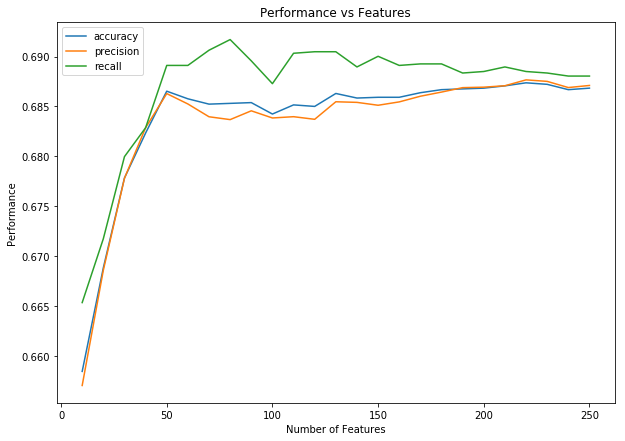

In [32]:
plt.figure(figsize=(10,7))
plt.plot(feat_count, log_acc, label = 'accuracy')
plt.plot(feat_count, log_pre, label = 'precision')
plt.plot(feat_count, log_recall, label = 'recall')
plt.legend()
plt.title('Performance vs Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
#plt.ylim((0.68, 0.74))
plt.show();

Fit and test the logistic model on the 50 most important features.

In [34]:
l = LogisticRegression(C = 0.01, 
                       penalty = 'l2',
                       solver = 'lbfgs', 
                       random_state = random_state)
l.fit(X[average_weights.iloc[0:50].Feature],y)
#X_test = pd.DataFrame(X_test, columns=downsampled.drop(labels = ['TARGET'], axis = 1).columns)
preds = l.predict(X_val[average_weights.iloc[0:50].Feature])
classification_report(y_val, preds)

Classification Report

Confusion Matrix
Predicted   0.0   1.0    All
True                        
0.0        4475  2068   6543
1.0        2041  4524   6565
All        6516  6592  13108

Accuracy: 68.65% 
Precision: 68.63% 
Recall: 68.91%


**ROC Curve**

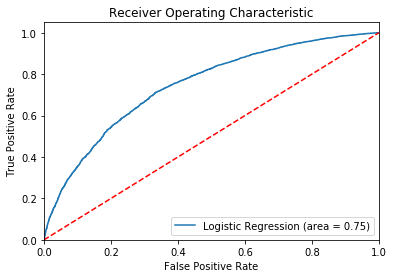

In [35]:
# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_val, l.predict_proba(X_val[average_weights.iloc[0:50].Feature])[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

#### Hist Gradient Boosting Machine

A HGBM was refit using 10 - 250 features in steps of 10 features.
The plot below shows that the performance of HGMB stabilizes after the 75 most important features were included in the model.

In [46]:
hgbm_acc = list()
hgbm_recall = list()
hgbm_pre = list()
feat_count = list()

clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = random_state)


for f_count in range(10,260,5):
    feat_count.append(f_count)
    
    clf.fit(X[average_weights.iloc[0:f_count].Feature], y)

    # using it on test set
    y_pred = clf.predict(X_val[average_weights.iloc[0:f_count].Feature])
    #results = confusion_matrix(y_test, y_pred)

    hgbm_acc.append(accuracy_score(y_val, y_pred))
    hgbm_pre.append(precision_score(y_val, y_pred))
    hgbm_recall.append(recall_score(y_val, y_pred))
    
    #classification_report(y_test, y_pred)

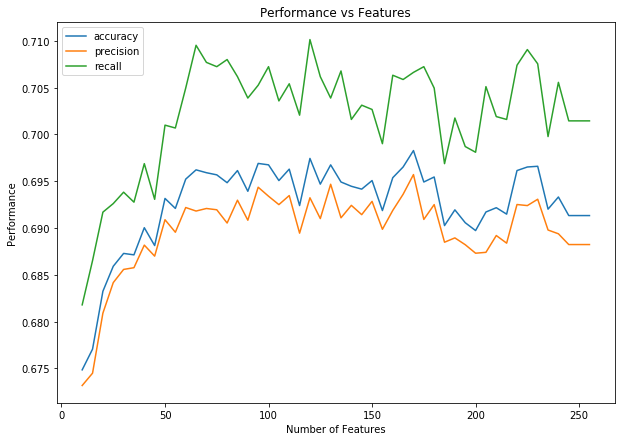

In [47]:
plt.figure(figsize=(10,7))
plt.plot(feat_count, hgbm_acc, label = 'accuracy')
plt.plot(feat_count, hgbm_pre, label = 'precision')
plt.plot(feat_count, hgbm_recall, label = 'recall')
plt.legend()
plt.title('Performance vs Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
#plt.ylim((0.68, 0.78))
plt.show();

Fit and test the HGBM model on the 75 most important features.

In [48]:
# prediction with all features
clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = random_state)



clf.fit(X[average_weights.iloc[0:75].Feature],y)

# using it on test set
y_pred = clf.predict(X_val[average_weights.iloc[0:75].Feature])
results = confusion_matrix(y_val, y_pred)

classification_report(y_val, y_pred)

Classification Report

Confusion Matrix
Predicted   0.0   1.0    All
True                        
0.0        4476  2067   6543
1.0        1922  4643   6565
All        6398  6710  13108

Accuracy: 69.57% 
Precision: 69.20% 
Recall: 70.72%


**ROC Curve**

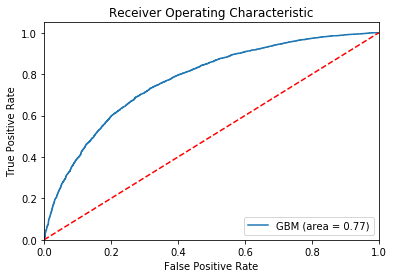

In [49]:

# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test[average_weights.iloc[0:75].Feature])[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'GBM (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

## Logistic Regression Parameter Grid Search <a class="anchor" id="GridSearch"></a>

Each type of regularized logistic regression was grid search for the best hyperparameters before fitting the model for estimating feature importances.

* L2 Regulaization
* L1 Regulaization
* Elastic Net Regulaization

### L2 Regulaization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ for L2 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

In [28]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'newton-cg',
                     'lbfgs',
                     'sag',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l2', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
# Fit on data
#best_clf = clf.fit(X_train_svm, y_train_svm)

# Tuning hyper-parameters for precision



/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_ite

KeyboardInterrupt: 

### l1 Regularization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘liblinear’ and ‘saga’ for L1 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

In [ ]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'liblinear',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l1', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

### Elastic Net

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-4, 4) with 10 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘saga’ for elastic-net
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 10 steps

In [ ]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':['saga'],
        'C':np.logspace(-4, 4, 10),
        'l1_ratio':np.linspace(0, 1, 10)
    }]

model = LogisticRegression(penalty = 'elasticnet', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
